In [202]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<h3> Scrapping the Data from the Wikepdia page using the BeatifulSoup Library </h3>

In [52]:
#Given URL of the Wikepedia Page
URL='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page =  requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

#find the table data in the returned dataset from the BeautifulSoup Library
postal_code_data = soup.find('table', attrs={'class':'wikitable sortable'})

#Defining the Regex expression to remove HTML tags 
cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

#finding all the values within the <td>..</td> elements
postal_code_data = postal_code_data.tbody.find_all('td')


In [53]:
#empty lists to store the table data
table_data=[]
temp_list=[]

#iterating through the reruned data from Beautifulsoup to extract the values within the <td>..</td> elements
for item in postal_code_data:
    
    # Since we know each row contains only 3 columns, hence appennding 3 items at once to a temp list to construct a row. 
    if len(temp_list) < 3: 
        temp_list.append(re.sub(cleanr, '', str(item).replace('\n', '').strip()))
    
    #Once the temp list is populated with 3 items i.e. 1 row, we empty the list, append the temp list to the table data list
    #and continue same as above.
    
    else:
        table_data.append(temp_list)
        temp_list=[]
        temp_list.append(re.sub(cleanr, '', str(item).replace('\n', '').strip()))
       
# Appending the last row to the table_data
table_data.append(temp_list)


<h3> Data Preparation </h3>

In [54]:
# Creating a DataFrame for postal codes of Canada
post_code_df = pd.DataFrame(table_data, columns=['PostalCode', 'Borough', 'Neighbourhood'])

# Removing rows with not assigned Boroughs
post_code_df = post_code_df[post_code_df['Borough']!='Not assigned']

# Replacing Not assigned neigbourhoods with the borough's names 
post_code_df['Neighbourhood'] = post_code_df.apply(lambda x : x.Borough  if x.Neighbourhood=='Not assigned' else x.Neighbourhood, axis=1 )
post_code_df

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [55]:
post_code_df.shape

(103, 3)

In [56]:
# reading the csv containing geospatial coordinates
df_coord = pd.read_csv('Geospatial_Coordinates.csv')
df_coord

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


<h3>Getting the Geospatial Coordinates from the CSV</h3>

In [57]:
# merging the dataframes containing geospatial coordinates and other data

post_code_df= post_code_df.merge(df_coord, how='inner', left_on='PostalCode', right_on = 'Postal Code')

post_code_df

,PostalCode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,43.662301,-79.389494
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",M8X,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",M7Y,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",M8Y,43.636258,-79.498509


<h2> Preparing Data for Cluster Analysis </h2>

In [60]:
# Getting boroughs containing the word Toronto
post_code_df = post_code_df[post_code_df['Borough'].str.contains('Toronto')]

post_code_df.drop(['Postal Code'], axis =1, inplace=True)

post_code_df


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


### Getting the geo coordinates of Toronto, Canada

In [68]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [70]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(post_code_df['Latitude'], post_code_df['Longitude'], post_code_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto) 

map_Toronto

### Next, utilising the foursquare API we will explore the neighbourhoods and explore them 

#### Defining the fourquare api credentials

In [260]:
CLIENT_ID = 'A2BC2RIVWYOF0AQFJO0BP2TT1YGQ0RZXRZTE2MHCAE0TP32O' # your Foursquare ID
CLIENT_SECRET = 'AHAXZ0NDOZUDTESEZU0YKWM3IFIX5OZHCWCYQEJZFT3W2QFF' # your Foursquare Secret
VERSION = '20210102' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value



Creating a function to get all nearby venues surrounding all the neighbourhoods

In [133]:
def get_nearby_venues(neighborhood, latitude, longitude):
    venues_list=[]
    
    for name, lat, long in zip(neighborhood, latitude, longitude):
        #print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
        
        results = requests.get(url).json()
        
        venues = results['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat,
            long,
            val['venue']['name'],
            val['venue']['location']['lat'],
            val['venue']['location']['lng'],
            val['venue']['categories'][0]['name']) for val in venues
            
        ])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
        
        
        
        

In [135]:
#creating a dataframe for all nearbuy venues for all neighbourhoods in Toronto
torronto_venues= get_nearby_venues(post_code_df.Neighbourhood,post_code_df.Latitude, post_code_df.Longitude)


(1630, 7)

In [170]:
torronto_venues = torronto_venues[torronto_venues['Venue Category']!='Neighborhood']
torronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.654260,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
5,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
6,"Regent Park, Harbourfront",43.654260,-79.360636,Corktown Common,43.655618,-79.356211,Park
7,"Regent Park, Harbourfront",43.654260,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
8,"Regent Park, Harbourfront",43.654260,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,"Regent Park, Harbourfront",43.654260,-79.360636,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop


In [171]:
torronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,63,63,63,63,63,63
Christie,16,16,16,16,16,16
Church and Wellesley,83,83,83,83,83,83
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,37,37,37,37,37,37


### Printing the unique categories in the dataset

In [139]:
print('There are {} uniques categories.'.format(len(torronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


## Analysing each neighbourhood 

In [176]:
# one hot encoding
torronto_encode = pd.get_dummies(torronto_venues[['Venue Category']],  prefix="", prefix_sep="")

# add neighborhood column back to dataframe
torronto_encode['Neighborhood'] = torronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [torronto_encode.columns[-1]] + list(torronto_encode.columns[:-1])
torronto_encode = torronto_encode[fixed_columns]

torronto_encode.head()
                                             

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [173]:
torronto_encode.shape

(1626, 236)

In [184]:
torronto_grouped = torronto_encode.groupby('Neighborhood').mean().reset_index()
torronto_grouped.set_index('Neighborhood', inplace =True)
torronto_grouped

,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.017241,0.034483,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000,0.034483,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.017241,0.017241,

### Printing the top 5 Venues for each neighborhood 

In [196]:
num_venues = 5
for val in torronto_grouped.index:
    print("----"+val+"----")
    temp= torronto_grouped.loc[val,:].T.reset_index()
    temp.columns = ['venue','freq']
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.10
1    Cocktail Bar  0.05
2        Beer Bar  0.03
3  Farmers Market  0.03
4      Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.14
1          Breakfast Spot  0.09
2             Coffee Shop  0.09
3            Climbing Gym  0.05
4  Furniture / Home Store  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Auto Workshop  0.06
3          Comic Shop  0.06
4                Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3   Harbor / Marina  0.06
4               Bar  0.06


----Central Bay Street----
                venue  f

In [198]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [200]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torronto_grouped.index

for ind in np.arange(torronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Restaurant,Beer Bar,Cheese Shop,Farmers Market,Basketball Stadium,Beach
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Garden Center,Brewery,Farmers Market,Fast Food Restaurant,Burrito Place,Butcher,Restaurant,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Sculpture Garden,Airport Food Court,Airport Gate,Bar,Boat or Ferry,Boutique
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Thai Restaurant,Bubble Tea Shop,Burger Joint,Ramen Restaurant,Indian Restaurant


## Cluster Analysis

#### Choosing the optimal number of clusters with the elbow method

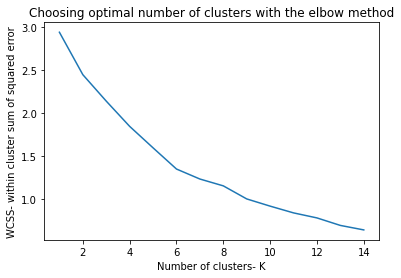

In [225]:
 

wcss=[]

#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list.

for i in range(1,15): 
     kmeans = KMeans(n_clusters=i, init ='k-means++',random_state=0 )
        
#i above is between 1-10 numbers. init parameter is the random #initialization method  
#we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
#find the final clusters when the K-meands algorithm is running. we #enter the default value of 300
#the next parameter is n_init which is the number of times the #K_means algorithm will be run with
#different initial centroid.

     kmeans.fit(torronto_grouped)
#kmeans algorithm fits to the X dataset
     wcss.append(kmeans.inertia_)
#kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
#4.Plot the elbow graph
plt.plot(range(1,15),wcss)
plt.title('Choosing optimal number of clusters with the elbow method')
plt.xlabel('Number of clusters- K')
plt.ylabel('WCSS- within cluster sum of squared error')
plt.show()

 From the above graph, we can see the first elbow is observed at K=2, which may not give distinct clusters to categorise venues. Also we observe an elbow at K=9, but in that case there will be too many clusters to interpret. 

 Hence, we choose k=6 as the optimal values of K, which gives us distinct amount of clusters which will be easy to interpret

In [234]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init ='k-means++', max_iter=500,  random_state=84 )
kmeans.fit(torronto_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 2, 0, 4, 0,
       0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0], dtype=int32)

In [247]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

torronto_merged = post_code_df
neighborhoods_venues_sorted
# merge torronto_grouped with post_code_df to add latitude/longitude for each neighborhood
torronto_merged = torronto_merged.merge(neighborhoods_venues_sorted, left_on='Neighbourhood', right_on = 'Neighborhood',
                                      how='inner')

torronto_merged.head() 

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,"Regent Park, Harbourfront",Coffee Shop,Bakery,Café,Park,Breakfast Spot,Pub,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Yoga Studio,Distribution Center,Bar,Beer Bar,Italian Restaurant,Japanese Restaurant,Smoothie Shop,Sandwich Place
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Hotel,Japanese Restaurant,Bubble Tea Shop,Bookstore,Italian Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,St. James Town,Coffee Shop,Café,Cocktail Bar,American Restaurant,Lingerie Store,Department Store,Gastropub,Restaurant,Gym,Hotel
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,The Beaches,Health Food Store,Pub,Trail,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant


Visualising the Clusters

In [249]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(torronto_merged['Latitude'], torronto_merged['Longitude'], torronto_merged['Neighborhood'], torronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###  Examining Clusters

Cluster 1: Majorly Consisting of Cafes

In [252]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 0, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,"Regent Park, Harbourfront",Coffee Shop,Bakery,Café,Park,Breakfast Spot,Pub,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,Downtown Toronto,0,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Yoga Studio,Distribution Center,Bar,Beer Bar,Italian Restaurant,Japanese Restaurant,Smoothie Shop,Sandwich Place
2,Downtown Toronto,0,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Hotel,Japanese Restaurant,Bubble Tea Shop,Bookstore,Italian Restaurant
3,Downtown Toronto,0,St. James Town,Coffee Shop,Café,Cocktail Bar,American Restaurant,Lingerie Store,Department Store,Gastropub,Restaurant,Gym,Hotel
5,Downtown Toronto,0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Restaurant,Beer Bar,Cheese Shop,Farmers Market,Basketball Stadium,Beach
6,Downtown Toronto,0,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Thai Restaurant,Bubble Tea Shop,Burger Joint,Ramen Restaurant,Indian Restaurant
7,Downtown Toronto,0,Christie,Grocery Store,Café,Park,Nightclub,Coffee Shop,Restaurant,Baby Store,Athletics & Sports,Candy Store,Italian Restaurant
8,Downtown Toronto,0,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Hotel,Gym,Thai Restaurant,Deli / Bodega,Sushi Restaurant,Salad Place,Burrito Place
9,West Toronto,0,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Supermarket,Brewery,Park,Bank,Grocery Store,Music Venue,Middle Eastern Restaurant,Bar
10,Downtown Toronto,0,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Restaurant,Brewery,Italian Restaurant,Scenic Lookout,History Museum


Cluster 2: Areas surrounding with park 


In [253]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 1, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,"Moore Park, Summerhill East",Park,Restaurant,Trail,Tennis Court,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant
33,Downtown Toronto,1,Rosedale,Park,Playground,Trail,Yoga Studio,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop


Cluster 3: Health Food Store

In [255]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 2, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,2,The Beaches,Health Food Store,Pub,Trail,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant


Cluster 4: Trail Venues

In [256]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 3, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,3,"Forest Hill North West, Forest Hill Road Park",Trail,Jewelry Store,Sushi Restaurant,Bus Line,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store


Cluser 5: Garden

In [257]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 4, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,4,Roselawn,Garden,Ice Cream Shop,Home Service,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio


Cluster 6: Parks Venue

In [259]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 5, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,5,Lawrence Park,Park,Swim School,Bus Line,Business Service,Farmers Market,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant
